<a href="https://colab.research.google.com/github/tanyarw/virtual-makeup/blob/main/virtual_makeup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount in drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#change file directory
import os
os.chdir("drive/My Drive/ML Lab/virtual makeup")

# Find facial features

In [3]:
import cv2
import sys
import numpy as np
import dlib
from google.colab.patches import cv2_imshow

Input Image

In [4]:
imgPath = "face1.jpg"
img = cv2.imread(imgPath)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Detect face using Haar Cascade

In [5]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.3,
        minNeighbors=3,
        minSize=(30, 30)
)

print("Found",len(faces),"Faces!".format())

Found 1 Faces!


Plot face detected

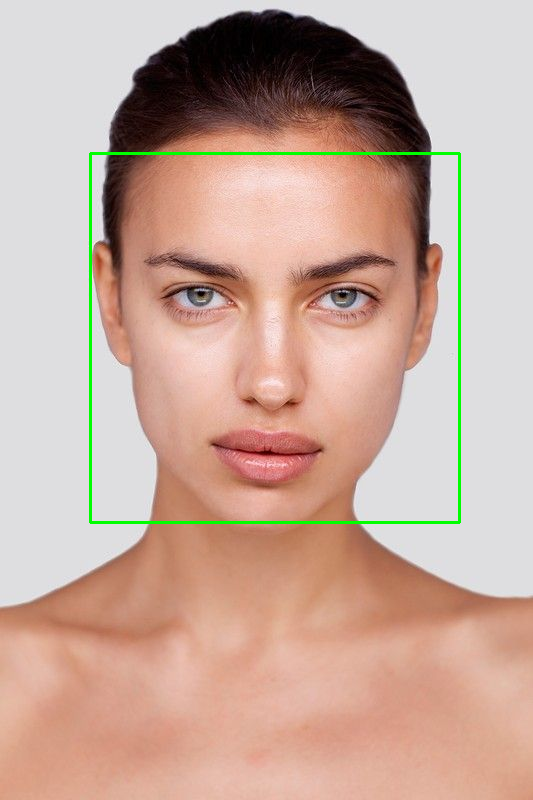

In [6]:
imgcpy1 = cv2.imread(imgPath) # copy of image
for (x, y, w, h) in faces:
    cv2.rectangle(imgcpy1, (x, y), (x+w, y+h), (0, 255, 0), 2)
cv2_imshow(imgcpy1)

Detect landmark features using dlip plots

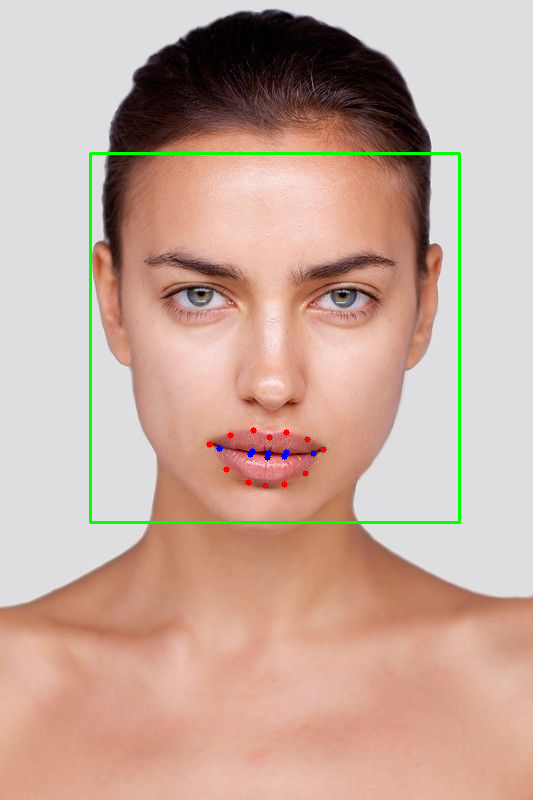

In [7]:
# outer lip coordinates
outer_lip_x = []
outer_lip_y = []
# inner lip coordinates
inner_lip_x = []
inner_lip_y = []

# Load the detector
detector = dlib.get_frontal_face_detector()
# Load the predictor
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Use detector to find landmarks
faces = detector(gray)
for face in faces:
    x1 = face.left() # left point
    y1 = face.top() # top point
    x2 = face.right() # right point
    y2 = face.bottom() # bottom point
    # Create landmark object
    landmarks = predictor(image=gray, box=face)
    # Loop through all the points
    with open('points.txt', 'w') as writefile:
      for n in range(0, 68):
          x = landmarks.part(n).x
          y = landmarks.part(n).y
          writefile.write(str(x)+" "+str(y)+"\n")

          # record lip coordinates
          if n in range(48,60):
            outer_lip_x.append(x)
            outer_lip_y.append(y)
            cv2.circle(img=imgcpy1, center=(x, y), radius=3, color=(0, 0, 255), thickness=-1) # plot outerlips
          if n in range(60,68):
            inner_lip_x.append(x)
            inner_lip_y.append(y)
            cv2.circle(img=imgcpy1, center=(x, y), radius=3, color=(255, 0, 0), thickness=-1) # plot innerlips
          

# show the image
cv2_imshow(imgcpy1)

# outer lip
outer_lip_x = np.array(outer_lip_x)
outer_lip_y = np.array(outer_lip_y)
# inner lip
inner_lip_x = np.array(inner_lip_x)
inner_lip_y = np.array(inner_lip_y)

# Add layers of "makeup"

In [8]:
from pylab import *
from scipy.interpolate import interp1d
from skimage import color
import matplotlib.pyplot as plt

In [15]:
b, g, r = (5., 20., 250.)  # lipstick color
outer_left_end = 4
outer_right_end = 7
inner_left_end = 3
inner_right_end = 5

In [16]:
def interpolate(lx, ly, k1='quadratic'):
    unew = np.arange(lx[0], lx[-1] + 1, 1) # evenly spaced values within given interval
    f2 = interp1d(lx, ly, kind=k1, fill_value="extrapolate")
    return f2, unew

Code for the curves bounding the lips

In [11]:
outer_upper_left = interpolate(outer_lip_x[:outer_left_end],
                    outer_lip_y[:outer_left_end])
outer_upper_right = interpolate(outer_lip_x[outer_left_end - 1:outer_right_end],
                    outer_lip_y[outer_left_end - 1:outer_right_end])

x1 = [outer_lip_x[0]] + outer_lip_x[outer_right_end - 1:][::-1].tolist()
y1 = [outer_lip_y[0]] + outer_lip_y[outer_right_end - 1:][::-1].tolist()
outer_lip = interpolate(x1, y1, 'cubic')

inner_upper_left = interpolate(inner_lip_x[:inner_left_end], inner_lip_y[:inner_left_end])
inner_upper_right = interpolate(inner_lip_x[inner_left_end - 1:inner_right_end], inner_lip_y[inner_left_end - 1:inner_right_end])

x2 = [inner_lip_x[0]] + inner_lip_x[inner_right_end - 1:][::-1].tolist()
y2 = [inner_lip_y[0]] + inner_lip_y[inner_right_end - 1:][::-1].tolist()
inner_lip = interpolate(x2, y2, 'cubic')



In [12]:
x = []  # will contain the x coordinates of points on lips
y = []  # will contain the y coordinates of points on lips

def extension(a, b, i):    
    a, b = np.round(a), np.round(b)
    x.extend(arange(a, b, 1, dtype=np.int32).tolist())
    y.extend((np.ones(int(b - a), dtype=np.int32) * i).tolist())

In [13]:
for i in range(int(outer_upper_left[1][0]), int(inner_upper_left[1][0] + 1)):
    extension(outer_upper_left[0](i), outer_lip[0](i) + 1, i)
for i in range(int(inner_upper_left[1][0]), int(outer_upper_left[1][-1] + 1)):
    extension(outer_upper_left[0](i), inner_upper_left[0](i) + 1, i)
    extension(inner_lip[0](i), outer_lip[0](i) + 1, i)

for i in range(int(inner_upper_right[1][-1]), int(outer_upper_right[1][-1] + 1)):
    extension(outer_upper_right[0](i), outer_lip[0](i) + 1, i)
for i in range(int(inner_upper_right[1][0]), int(inner_upper_right[1][-1] + 1)):
    extension(outer_upper_right[0](i), inner_upper_right[0](i) + 1, i)
    extension(inner_lip[0](i), outer_lip[0](i) + 1, i)
# Now x and y contains coordinates of all the points on lips

Plot the lipstick layer

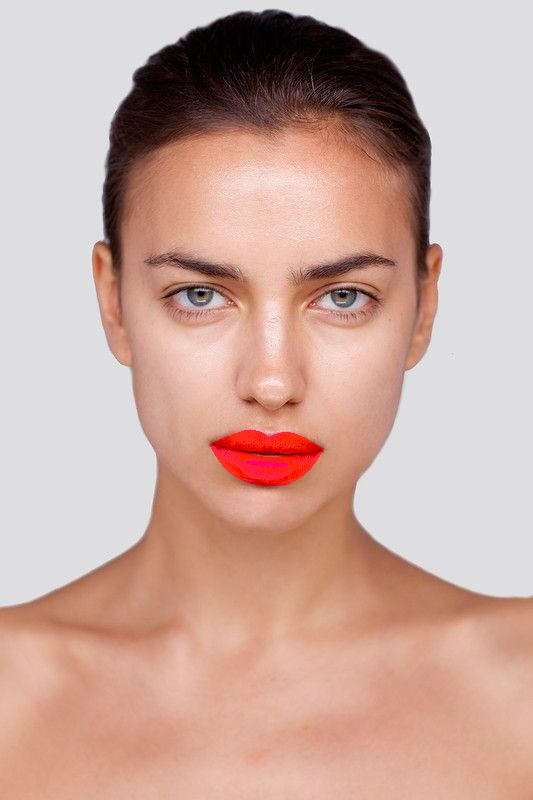

In [17]:
val = color.rgb2lab((img[x, y] / 255.).reshape(len(x), 1, 3)).reshape(len(x), 3)
L, A, B = mean(val[:, 0]), mean(val[:, 1]), mean(val[:, 2])
L1, A1, B1 = color.rgb2lab(np.array((b / 255., g / 255., r / 255.)).reshape(1, 1, 3)).reshape(3, )
L2, A2, B2  = L1 - L, A1 - A, B1 - B
val[:, 0] += L2
val[:, 1] += A2
val[:, 2] += B2

img[x, y] = color.lab2rgb(val.reshape(len(x), 1, 3)).reshape(len(x), 3) * 255
cv2_imshow(img)